This is where we do the analysis for the paper.

*Note:* pickled embeddings are generated with code in included in the Appendix section at the end of the notebook.

In [2]:
%pylab inline
import sys
# import words
import we
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
import numpy as np
import re, sys
import random
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import sklearn.feature_selection 
import csv
from collections import Counter
import json
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
import time
from sklearn.cluster import KMeans
import scipy.stats
from sklearn.model_selection import KFold

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data pre-processing

In [3]:
with open("data/cockamamie_gobbledegook_us_data.json", "r") as f: 
    cockamamie_gobbledegook_us_data = json.load(f)

In [4]:
cockamamie_gobbledegook_us_data.keys()

dict_keys(['word_features', 'word_ratings'])

In [5]:
labels = cockamamie_gobbledegook_us_data["word_features"]
" ".join(labels.keys())

'snd scatc clq inslt juxt sexc'

In [6]:
workers = cockamamie_gobbledegook_us_data["word_ratings"]["workers"]
len(workers)

1878

In [7]:
votes = cockamamie_gobbledegook_us_data["word_ratings"]["votes"]

In [8]:
# Data from https://link.springer.com/article/10.3758/s13428-017-0930-6
!wget https://github.com/tomasengelthaler/HumorNorms/blob/master/humor_dataset.csv
with open("humor_dataset.csv", "r") as f:
    foo = [line.strip().split(",") for line in f.readlines()]
    headings = foo[0][1:]
    others = {line[0]: {feat: float(v) for v, feat in zip(line[1:], headings)} for line in foo[1:]}

# E_other.filter_words(lambda w: w in others)
EH_scores = {w: others[w]["mean"] for w in others}
print(len(EH_scores))
# print(len(other_scores), "words in the embedding")

4997


# Helper functions

In [9]:
def corr(a,b):
    return corrcoef(a,b)[0,1]

def normalize(v):
    return v / np.linalg.norm(v)
    
def revsorted(*args, **kw_args):
    return sorted(*args, **kw_args, reverse=True)

In [10]:
filename = "data/crawl-300d-120k-subword_w_EH.pkl"
with open(filename, "rb") as f:
    E_fast = pkl.load(f)
print(f"Loaded {len(E_fast):,} words from {filename}")

Loaded 120,259 words from data/crawl-300d-120k-subword_w_EH.pkl


In [11]:
filename = "data/crawl-300d-120k-w_EH.pkl"
with open(filename, "rb") as f:
    E_fast_whole = pkl.load(f)
print(f"Loaded {len(E_fast_whole):,} words from {filename}")

Loaded 120,259 words from data/crawl-300d-120k-w_EH.pkl


In [12]:
filename = "data/wiki-news-300d-120kEH-subword.pkl"
with open(filename, "rb") as f:
    E_wiki = pkl.load(f)
print(f"Loaded {len(E_wiki):,} words from {filename}")

Loaded 120,259 words from data/wiki-news-300d-120kEH-subword.pkl


In [13]:
# wiki (glove)
filename = "data/glove_840_w_EH.pkl"
with open(filename, "rb") as f:
    E_glove = pkl.load(f)
print(f"Loaded {len(E_glove):,} words from {filename}")

Loaded 120,259 words from data/glove_840_w_EH.pkl


In [14]:
filename = "data/w2v_w_EH.pkl"
with open(filename, "rb") as f:
    E = pkl.load(f)
print(f"Loaded {len(E):,} words from {filename}")

Loaded 120,259 words from data/w2v_w_EH.pkl


In [15]:
wordss = [sorted(ws) for ws in votes]

In [16]:
# extract demographic group votes
def sex(worker_id):
    return workers[worker_id]["sex"]

votes_M = [{w: {k: [i for i in v if sex(i)=='Male'] for k, v in vv.items()} for w, vv in vvv.items()} for vvv in votes]
votes_F = [{w: {k: [i for i in v if sex(i)=='Female'] for k, v in vv.items()} for w, vv in vvv.items()} for vvv in votes]

scores_M = [{w: len(v[w]["yes_votes"])/len(v[w]["yes_votes"] + v[w]["no_votes"]) for w in v if len(v[w]["yes_votes"] + v[w]["no_votes"])} for v in votes_M]
scores_F = [{w: len(v[w]["yes_votes"])/len(v[w]["yes_votes"] + v[w]["no_votes"]) for w in v if len(v[w]["yes_votes"] + v[w]["no_votes"])} for v in votes_F]
def age(worker_id, default=35):
    a = workers[worker_id]['age']
    return default if type(a) is str else a
    
ages = [age(worker['id']) for worker in workers]
mean([a>32 for a in ages]), mean(ages), median(ages)

(0.6112886048988285, 37.685303514377, 35.0)

# EH correlation with embedding vectors

In [18]:
def cross_val_corr_w_std(words, scores, n_reps=1, n_folds=10, clr = LinearRegression(), E=E):
    MSEs = []
    correlations = []
    for rep in range(n_reps):
        kf = KFold(n_splits=n_folds, random_state=rep, shuffle=True)    
        word_predict = {}
        tot_error = 0
        for train,test in kf.split(words):
            train_words = [words[i] for i in train]
            test_words = [words[i] for i in test]
#             print(len(train_words), len(test_words))
            X_train, X_test = [[E[w] for w in _words] for _words in (train_words, test_words)]
            y_train, y_test = [[scores[w] for w in _words] for _words in (train_words, test_words)]
            clr.fit(X_train, y_train)
            y_hat = clr.predict(X_test)
            word_predict.update({w: _y_hat for w, _y_hat in zip(test_words, y_hat)})
            tot_error += np.sum(np.square(y_hat-y_test))
        MSEs.append(tot_error/len(words))
        correlations.append(corr([word_predict[w] for w in words], [scores[w] for w in words]))
    return mean(correlations), std(correlations)*1.96

def cross_val_corr(words, scores, n_reps=1, n_folds=10, clr = LinearRegression(), E=E):
    return cross_val_corr_w_std(words, scores, n_reps, n_folds, clr, E)[0]

In [161]:
# Fit linear regression to predict scores from given embedding word vectors (words all from EH dataset). 
def scatter_embedding(E, n_reps=1, fig_gen=True, save_filename=None, size=0.5):
    clr = LinearRegression()
    clr.fit([E[w] for w in EH_scores], [EH_scores[w] for w in EH_scores]) 
    test_words = [w for w in EH_scores]
    y_test = [EH_scores[w] for w in test_words]
    y_hat = clr.predict([E[w] for w in test_words])
    if fig_gen:
        figure(figsize=(4,3))
        scatter(y_hat, y_test, s=size)
        plt.xlabel('predicted humor rating')
        plt.ylabel('humor rating from EH')
        plt.tight_layout()
        if save_filename:
            plt.savefig(save_filename, dpi=300)
    return corr(y_test, y_hat), cross_val_corr_w_std([w for w in EH_scores], EH_scores, n_reps=n_reps,E=E)

(0.7676527627145961, (0.7308429037126, 0.0))

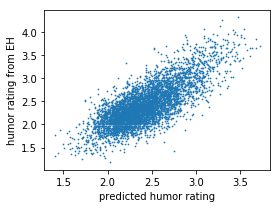

In [119]:
# glove
scatter_embedding(E_glove)

(0.7591718252251429, (0.7201045633364683, 0.0))

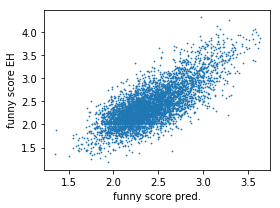

In [21]:
# wiki (fasttext)
scatter_embedding(E_wiki)

(0.721111800654958, (0.6728484567755527, 0.0))

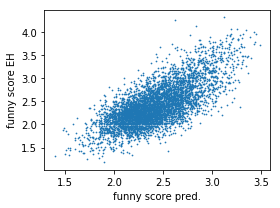

In [22]:
# word2vec
scatter_embedding(E)

In [80]:
!ls figs

EH_funny_corr.jpg  feature_correlations.jpg  feature_correlations.pdf


(0.7670415023362466, (0.7278385811900658, 0.0))

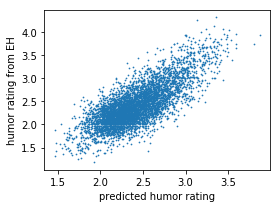

In [162]:
#  FASTTEXT subwords
scatter_embedding(E_fast, save_filename="figs/EH_funny_corr.jpg")

(0.7672975967458391, (0.728087647637513, 0.0))

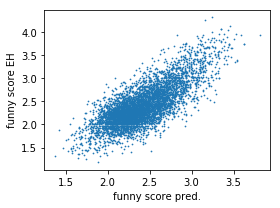

In [24]:
#  FASTTEXT
scatter_embedding(E_fast_whole)

In [ ]:
# Using 100 repetitions

# \begin{tabular}{lll}\toprule
# Embedding name & Corr. & Corr. (using CV)\\\midrule
# GNEWS                & 0.721 & 0.675 \pm 0.003\\
# WebSubword           & 0.767 & 0.729 \pm 0.002\\
# Web                  & 0.767 & 0.730 \pm 0.002\\
# WikiGiga             & 0.678 & 0.619 \pm 0.003\\
# Twitter              & 0.686 & 0.650 \pm 0.002\\
# \bottomrule
# \end{tabular}

In [123]:
%%time
NREPS = 100 # used to generate the figures in the paper -- takes about 10 minutes
# NREPS = 10 # takes only 1 minute
# Geneate embedding comparison table content
embed_comp_corr_table = {}
embeddings_to_try = [(E, "GNEWS (word2vec)"), (E_fast,'WebSubword (fastText)'), (E_fast_whole,'WebFast (fastText)'),\
                     (E_glove, "WebGlove (gloVe)")]
for embed in embeddings_to_try:
    results = scatter_embedding(embed[0], n_reps=NREPS, fig_gen=False)
    embed_comp_corr_table[embed[1]] = [results[0], results[1][0], results[1][1]]

CPU times: user 1h 45s, sys: 4h 24min 23s, total: 5h 25min 8s
Wall time: 10min 12s


In [124]:
print(f"Using {NREPS} repetitions")
print()
# Generate latex-style table, see Table 1 in paper
print(r"\begin{tabular}{lll}\toprule")
print(" & ".join(["Embedding name", "Corr.", "Corr. (using CV)"])+r"\\\midrule")
for key,val in embed_comp_corr_table.items():
    print(f"{key:22} & {val[0]:5.3f} & {val[1]:5.3f} $\pm$ {val[2]:5.3f}\\\\")
#     print("{}     & ".format(key), " & ".join([str(round(v,3)) for v in val]) + r"\\")
print("\\bottomrule")
print(r"\end{tabular}")

Using 100 repetitions

\begin{tabular}{lll}\toprule
Embedding name & Corr. & Corr. (using CV)\\\midrule
GNEWS (word2vec)       & 0.721 & 0.675 $\pm$ 0.003\\
WebSubword (fastText)  & 0.767 & 0.729 $\pm$ 0.002\\
Web (fastText)         & 0.767 & 0.730 $\pm$ 0.002\\
WebGlove (gloVe)       & 0.768 & 0.730 $\pm$ 0.002\\
\bottomrule
\end{tabular}


In [29]:
# # Generate latex-style table, see Table 1 in paper
# print(r"\begin{tabular}{lll}\toprule")
# print(" & ".join(["Embedding name", "Correlation", "Corr. w. hold-out", "std."])+r"\\\midrule")
# for key,val in embed_comp_corr_table.items():
#     print(f"{key:20} & {val[0]:5.3f} & {val[1]:5.3f} \pm {\val[2]:.1}")
# #     print("{}     & ".format(key), " & ".join([str(round(v,3)) for v in val]) + r"\\")
# print("\\bottomrule")
# print(r"\end{tabular}")

# \begin{tabular}{lllr}\toprule
# Embedding name & Correlation & Corr. w. hold-out & std.\\\midrule
# w2v     &  0.721 & 0.675 & 0.003\\
# FastText subword     &  0.767 & 0.729 & 0.002\\
# FastText wholeword     &  0.767 & 0.73 & 0.002\\
# Glove     &  0.678 & 0.619 & 0.002\\
# Glove Twitter     &  0.686 & 0.65 & 0.002\\
# \bottomrule
# \end{tabular}

\begin{tabular}{lllr}\toprule
Embedding name & Correlation & Corr. w. hold-out & std.\\\midrule
w2v     &  0.721 & 0.675 & 0.003\\
FastText subword     &  0.767 & 0.729 & 0.002\\
FastText wholeword     &  0.767 & 0.73 & 0.002\\
Glove     &  0.678 & 0.619 & 0.002\\
Glove Twitter     &  0.686 & 0.65 & 0.002\\
\bottomrule
\end{tabular}


In [69]:
# Funniest predicted words
_union = sorted((wordss[0] + list(EH_scores)))

clr = LinearRegression()
clr.fit([E[w] for w in EH_scores], [EH_scores[w] for w in EH_scores])
predictions = {w: v for (w,v) in zip(_union,clr.predict([E[w] for w in _union]))}
print([(w +"*" if w in EH_scores else w, predictions[w]) for w in sorted(_union, key=lambda x: predictions[x], reverse=True)[:10]])
print(", ".join([w+"*" if w in EH_scores else w.replace("_", " ") for w in sorted(_union, key=lambda x: predictions[x], reverse=True)[:10]]))
print("* means word is in EH")

[('badinage', 3.7316594), ('goofballs', 3.6911929), ('har_har', 3.6085882), ('peeps', 3.6019015), ('tee_hee', 3.5971272), ('zany_antics', 3.5947742), ('wank', 3.5768852), ('meisters', 3.5689101), ('dippy', 3.5637324), ('gyration', 3.5612454)]
badinage, goofballs, har har, peeps, tee hee, zany antics, wank, meisters, dippy, gyration
* means word is in EH


In [68]:
print("Funniest words in EH paper:")
", ".join(sorted(EH_scores, key = lambda w: -EH_scores[w])[:12])

Funniest words in EH paper:


'booty, tit, hooter, booby, nitwit, waddle, twit, tinkle, twerp, egghead, floozy, oomph'

# clustering (group difference analysis)

In [86]:
# votes[0]: votes from 120k round
# votes[1]: votes from 8k round
# votes[2]: votes from 216, first part
# votes[3]: votes from 216, second part
# votes[4]: votes from 36
# votes[5]: votes fro 6 word round (final)

In [19]:
# constructing full list of voters. wordss[2][0] is the first word, random choice of word, not a meaningful one
round2_voters = sorted(votes[2][wordss[2][0]]["yes_votes"] + votes[2][wordss[2][0]]["no_votes"])
# a list of voters, and a dictionary with each individual's votes for each word w 
round2_hashes = [{w: 1 if u in votes[2][w]["yes_votes"] else 0 for w in wordss[2]} for u in round2_voters]
round2_voters == list(range(len(round2_voters)))

True

# w2v clusters 

K= 2, Silhouette score=0.078, inertia=171.219 sex_delta=6.5%
K= 3, Silhouette score=0.049, inertia=164.439 sex_delta=17.3%
K= 4, Silhouette score=0.042, inertia=160.137 sex_delta=26.9%
K= 5, Silhouette score=0.038, inertia=157.618 sex_delta=34.9%
K= 6, Silhouette score=0.032, inertia=155.454 sex_delta=27.0%
K= 7, Silhouette score=0.031, inertia=153.654 sex_delta=34.0%
K= 8, Silhouette score=0.025, inertia=152.238 sex_delta=34.0%
K= 9, Silhouette score=0.026, inertia=151.114 sex_delta=36.2%
K=10, Silhouette score=0.026, inertia=150.192 sex_delta=32.9%
K=20, Silhouette score=0.016, inertia=144.112 sex_delta=41.1%


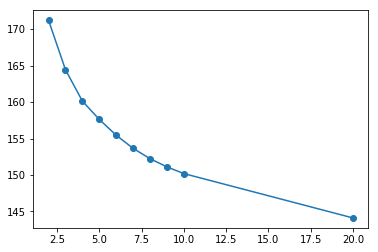

In [23]:
# choose number of clusters for KMeans neighbours with 'elbow method'
rand_state = 2
from sklearn.metrics import silhouette_score

Ks = [2,3,4,5,6,7,8,9,10,20]
inertias = []
for K in Ks:
    kmeans = KMeans(n_clusters=K, random_state=rand_state)
    means = [normalize(np.sum([E[w]*(hash2[w]) for w in hash2], axis=0)) for hash2 in round2_hashes]
#     groups are male vs. non-male voters (female+other)
    sexes = [sex(u)=='Male' for u in round2_voters]
    ages = [age(u) for u in round2_voters]
    kmeans.fit(means)
    clusters = [[i for i, l in enumerate(kmeans.labels_) if l==k] for k in range(K)]
    sexes = [mean([sexes[i] for i in cluster]) for cluster in clusters]
    print(f"K={K:2}, Silhouette score={silhouette_score(means, kmeans.labels_):.3f}, inertia={kmeans.inertia_:.3f} sex_delta={max(sexes)-min(sexes):.1%}")
    inertias.append(kmeans.inertia_)
    
plot(Ks, inertias, marker='o')

In [23]:
# we chose K = 5 clusters based on elbow method

In [24]:
# generate 5 clusters with KMeans algorithm
K = 5
kmeans = KMeans(n_clusters=K, random_state=rand_state)
means = [normalize(np.sum([E[w]*(hash2[w]>0) for w in hash2], axis=0)) for hash2 in round2_hashes]
sexes = [sex(u)=='Female' for u in round2_voters]
ages = [age(u) for u in round2_voters]
kmeans.fit(means)

clusters = [[i for i, l in enumerate(kmeans.labels_) if l==k] for k in range(K)]
clusters.sort(key=lambda cluster: mean([-sexes[i] for i in cluster]))

for k, cluster in enumerate(clusters):
    best_words= revsorted(wordss[2], key=lambda w: mean([round2_hashes[i][w] for i in cluster])-mean([hash2[w] for hash2 in round2_hashes]))
    print("Cluster {:5.2f} {:5.1f} ({:3}): {}".format(mean([sexes[i] for i in cluster]), median([ages[i] for i in cluster]), len(cluster), " ".join(best_words)[:130]))

Cluster  0.70  35.0 (354): gobbledegook kerfuffle hullaballoo razzmatazz gazumped boondoggle galumphing skedaddle higgledy_piggledy guffawing bamboozle glock
Cluster  0.58  35.0 (273): tootsies fufu squeegee woo_woo doohickey weenies muumuu thingies wigwams yadda_yadda weaner peewee caboose goop nookie doodad toon
Cluster  0.54  41.0 (340): clusterfuck batshit crapola apeshit fugly wanker schmuck arseholes dickheads douchebaggery knuckleheads bitch_slap artsy_fartsy nu
Cluster  0.52  35.0 (309): cockle_pickers whakapapa codswallop bacon_butties dabbawalas woolly_buggers higgledy_piggledy annus_horribilis trillion_dong pooja
Cluster  0.35  33.0 (383): sexual_napalm semen_samples crack_whore bitch_slap dickheads blue_tits nut_flush twat butt_cheeks cocking rat_ass titties pooch_pu


In [25]:
females = [sex(u)=='Female' for u in round2_voters]
great_cats = {"sexc":"sexual", "scatc":"scatological", "inslt": "insults", "clq": "colloqial", "juxt": "juxtapos.", "snd": "sound"}
great_cat_list = ["snd", "scatc", "clq", "inslt", "juxt", "sexc"]
assert(sorted(great_cats)==sorted(great_cat_list))
words = [w for w in wordss[2] if "_" not in w] # wordss[2]

# Given funny features and cluster, returns the mean score for that feature,cluster pair
def score_cat_cluster(cat, cluster):
    return mean([labels[cat][w]*round2_hashes[i][w] for i in cluster for w in wordss[2]])/mean([labels[cat][w]*hash2[w] for hash2 in round2_hashes for w in wordss[2]])
# Generate sa well-fromatted line for table of all mean cluster scores for that feature category
def cat_string(cat):
    ss = [score_cat_cluster(cat, cluster) for cluster in clusters]
    return " & ".join(["{:19.2f}".format(s) if s!=max(ss) else r"\textbf{" + "{:.2f}".format(s)+"}" for s in ss])

# Generate latex-style table, see Table 3 in paper
print(r"\begin{tabular}{l" + "l"*K+r"}\toprule")
print(" "*12 + "&", " & ".join(["Cluster " + str(i).ljust(10) for i in range(1,K+1)])+r"\\\midrule")
for i in range(10):
    print("word {}      & ".format(i+1), " & ".join([revsorted(words, key=lambda w: mean([round2_hashes[i][w] for i in cluster])-mean([hash2[w] for hash2 in round2_hashes]))[i].ljust(18).replace("_", " ") for cluster in clusters]) + r"\\")
print("\\midrule")
for cat in great_cat_list:    
    print(great_cats[cat].ljust(12)+ "& " + cat_string(cat) + r"\\")
print("\\midrule")
print("female \\%".ljust(12)+ "& " + (" {:.1%}            & "*K).format(*[mean([females[i] for i in cluster]) for cluster in clusters])[:-3].replace("%", r"\%") + r"\\")
print("mean age".ljust(12)+ "& " + (" {:.1f}                & "*K).format(*[mean([ages[i] for i in cluster]) for cluster in clusters])[:-3] + r"\\")

\begin{tabular}{llllll}\toprule
            & Cluster 1          & Cluster 2          & Cluster 3          & Cluster 4          & Cluster 5         \\\midrule
word 1      &  gobbledegook       & tootsies           & clusterfuck        & whakapapa          & dickheads         \\
word 2      &  kerfuffle          & fufu               & batshit            & codswallop         & twat              \\
word 3      &  hullaballoo        & squeegee           & crapola            & dabbawalas         & cocking           \\
word 4      &  razzmatazz         & doohickey          & apeshit            & pooja              & titties           \\
word 5      &  gazumped           & weenies            & fugly              & spermatogenesis    & asshattery        \\
word 6      &  boondoggle         & muumuu             & wanker             & diktats            & nutted            \\
word 7      &  galumphing         & thingies           & schmuck            & annulus            & dong              \\
w

In [26]:
def p_value_sexes(n_samples=10**7):
    random.seed(0)
# compute cluster significance values
    sexes2 = females[:]
    res = []
    for i in range(n_samples//len(clusters)):
        random.shuffle(sexes2)
        res += [mean([sexes2[i] for i in cluster]) for cluster in clusters]
    res.sort()
    print("mean", mean(res))
    print(1/n_samples, res[0])
    print(10/n_samples, res[10])
    print("1%", res[n_samples//100])
    print("5%", res[n_samples//20])
    print("95% confidence interval [", res[n_samples//40], res[-n_samples//40], "]")
    print("95%", res[n_samples - n_samples//20])
    print("99%", res[n_samples - n_samples//100])
    print(1-10/n_samples, res[-10])
    print(1-1/n_samples, res[-1])

print("p values sexes")
p_value_sexes()

p values sexes
mean 0.534058934984079
1e-07 0.39194139194139194
1e-06 0.4139194139194139
1% 0.47619047619047616
5% 0.49411764705882355
95% confidence interval [ 0.4854368932038835 0.5824175824175825 ]
95% 0.575091575091575
99% 0.5922330097087378
0.999999 0.6593406593406593
0.9999999 0.6703296703296703


In [27]:
def p_value_ages(n_samples=10**7):
    random.seed(0)
# compute cluster significance values
    ages2= ages[:]
    res = []
    for i in range(n_samples//len(clusters)):
        random.shuffle(ages2)
        res += [mean([ages2[i] for i in cluster]) for cluster in clusters]
    res.sort()
    print("mean", mean(res))
    print(1/n_samples, res[0])
    print(10/n_samples, res[10])
    print("0.1%", res[n_samples//1000])
    print("1%", res[n_samples//100])
    print("5%", res[n_samples//20])
    print("95% confidence interval [", res[n_samples//40], res[-n_samples//40], "]")
    
    print("95%", res[n_samples - n_samples//20])
    print("99%", res[n_samples - n_samples//100])
    print(1-10/n_samples, res[-10])
    print(1-1/n_samples, res[-1])

print("p values ages")
p_value_ages()

p values ages
mean 37.99699438492871
1e-07 34.89010989010989
1e-06 35.18122977346278
0.1% 36.201465201465204
1% 36.65567765567766
5% 37.05084745762712
95% confidence interval [ 36.86813186813187 39.13915857605178 ]
95% 38.95145631067961
99% 39.36158192090395
0.999999 40.95238095238095
0.9999999 41.73626373626374


# FastText clustering

K= 2, Silhouette score=0.117, inertia=101.483 sex_delta=13.6%
K= 3, Silhouette score=0.069, inertia=97.513 sex_delta=16.4%
K= 4, Silhouette score=0.064, inertia=94.341 sex_delta=19.5%
K= 5, Silhouette score=0.047, inertia=92.228 sex_delta=24.1%
K= 6, Silhouette score=0.048, inertia=90.530 sex_delta=26.8%
K= 7, Silhouette score=0.047, inertia=89.414 sex_delta=27.9%
K= 8, Silhouette score=0.041, inertia=88.476 sex_delta=29.0%
K= 9, Silhouette score=0.037, inertia=87.738 sex_delta=31.6%
K=10, Silhouette score=0.032, inertia=86.954 sex_delta=36.3%
K=20, Silhouette score=0.023, inertia=82.655 sex_delta=41.0%


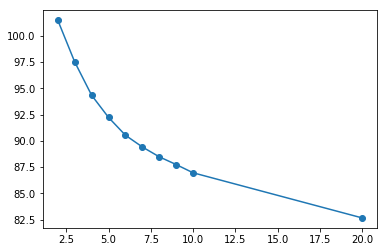

In [277]:
# choose number of clusters for KMeans neighbours with 'elbow method'
rand_state = 2
from sklearn.metrics import silhouette_score

Ks = [2,3,4,5,6,7,8,9,10,20]
inertias = []
for K in Ks:
    kmeans = KMeans(n_clusters=K, random_state=rand_state)
    means = [normalize(np.sum([E_fast[w]*(hash2[w]) for w in hash2], axis=0)) for hash2 in round2_hashes]
#     groups are male vs. non-male voters (female+other)
    sexes = [sex(u)=='Male' for u in round2_voters]
    ages = [age(u) for u in round2_voters]
    kmeans.fit(means)
    clusters = [[i for i, l in enumerate(kmeans.labels_) if l==k] for k in range(K)]
    sexes = [mean([sexes[i] for i in cluster]) for cluster in clusters]
    print(f"K={K:2}, Silhouette score={silhouette_score(means, kmeans.labels_):.3f}, inertia={kmeans.inertia_:.3f} sex_delta={max(sexes)-min(sexes):.1%}")
    inertias.append(kmeans.inertia_)
    
plot(Ks, inertias, marker='o')

In [278]:
# generate 5 clusters with KMeans algorithm
K = 4
kmeans = KMeans(n_clusters=K, random_state=rand_state)
means = [normalize(np.sum([E_fast[w]*(hash2[w]>0) for w in hash2], axis=0)) for hash2 in round2_hashes]
sexes = [sex(u)=='Female' for u in round2_voters]
ages = [age(u) for u in round2_voters]
kmeans.fit(means)

clusters = [[i for i, l in enumerate(kmeans.labels_) if l==k] for k in range(K)]
clusters.sort(key=lambda cluster: mean([-sexes[i] for i in cluster]))

for k, cluster in enumerate(clusters):
    best_words= revsorted(wordss[2], key=lambda w: mean([round2_hashes[i][w] for i in cluster])-mean([hash2[w] for hash2 in round2_hashes]))
    print("Cluster {:5.2f} {:5.1f} ({:3}): {}".format(mean([sexes[i] for i in cluster]), median([ages[i] for i in cluster]), len(cluster), " ".join(best_words)[:130]))

Cluster  0.63  35.0 (336): gobbledegook skedaddle kerfuffle hullaballoo lollygag schmaltzy bamboozle galumphing boondoggle bupkis glockenspiel dunderheaded g
Cluster  0.59  35.0 (437): whakapapa dabbawalas gazumped didgeridoo pickleball higgledy_piggledy portaloos tiddlywinks razzmatazz piggeries galumphing hippoc
Cluster  0.51  39.0 (394): clusterfuck batshit fugly apeshit wanker asshattery crapola dickheads douchebaggery arseholes bitch_slap nutjobs mofo goober dingb
Cluster  0.43  34.0 (492): cockle_pickers sexual_napalm blue_tits trillion_dong nut_flush pooch_punt nut_butters semen_samples cock_ups annus_horribilis puss


In [259]:
# 5 clusters seemed better than 4. For 4 we see a bunch of features collapsed into cluster 4 etc.
females = [sex(u)=='Female' for u in round2_voters]
great_cats = {"sexc":"sexual", "scatc":"scatological", "inslt": "insults", "clq": "colloqial", "juxt": "juxtapos.", "snd": "sound"}
great_cat_list = ["snd", "scatc", "clq", "inslt", "juxt", "sexc"]
assert(sorted(great_cats)==sorted(great_cat_list))
words = [w for w in wordss[2] if "_" not in w] # wordss[2]

# Given funny features and cluster, returns the mean score for that feature,cluster pair
def score_cat_cluster(cat, cluster):
    return mean([labels[cat][w]*round2_hashes[i][w] for i in cluster for w in wordss[2]])/mean([labels[cat][w]*hash2[w] for hash2 in round2_hashes for w in wordss[2]])
# Generate sa well-fromatted line for table of all mean cluster scores for that feature category
def cat_string(cat):
    ss = [score_cat_cluster(cat, cluster) for cluster in clusters]
    return " & ".join(["{:19.2f}".format(s) if s!=max(ss) else r"\textbf{" + "{:.2f}".format(s)+"}" for s in ss])

# Generate latex-style table, see Table 3 in paper
print(r"\begin{tabular}{l" + "l"*K+r"}\toprule")
print(" "*12 + "&", " & ".join(["Cluster " + str(i).ljust(10) for i in range(1,K+1)])+r"\\\midrule")
for i in range(10):
    print("word {}      & ".format(i+1), " & ".join([revsorted(words, key=lambda w: mean([round2_hashes[i][w] for i in cluster])-mean([hash2[w] for hash2 in round2_hashes]))[i].ljust(18).replace("_", " ") for cluster in clusters]) + r"\\")
print("\\midrule")
for cat in great_cat_list:    
    print(great_cats[cat].ljust(12)+ "& " + cat_string(cat) + r"\\")
print("\\midrule")
print("female \\%".ljust(12)+ "& " + (" {:.1%}            & "*K).format(*[mean([females[i] for i in cluster]) for cluster in clusters])[:-3].replace("%", r"\%") + r"\\")
print("mean age".ljust(12)+ "& " + (" {:.1f}                & "*K).format(*[mean([ages[i] for i in cluster]) for cluster in clusters])[:-3] + r"\\")

\begin{tabular}{lllll}\toprule
            & Cluster 1          & Cluster 2          & Cluster 3          & Cluster 4         \\\midrule
word 1      &  gobbledegook       & whakapapa          & clusterfuck        & spermatogenesis   \\
word 2      &  skedaddle          & dabbawalas         & batshit            & cocking           \\
word 3      &  kerfuffle          & gazumped           & fugly              & cockling          \\
word 4      &  hullaballoo        & didgeridoo         & apeshit            & cockfights        \\
word 5      &  lollygag           & pickleball         & wanker             & titties           \\
word 6      &  schmaltzy          & portaloos          & asshattery         & jerkbaits         \\
word 7      &  bamboozle          & tiddlywinks        & crapola            & annulus           \\
word 8      &  galumphing         & razzmatazz         & dickheads          & shuttlecock       \\
word 9      &  boondoggle         & piggeries          & douchebaggery 

# know your audience

In [163]:
# words each person found funniest
winners = [w for u in round2_voters for w in wordss[2] if u in votes[4][w]["yes_votes"]]
# create tuples of individuals who are 'comic opposites', i.e. found different words funny
comic_opposites = [(i, j) for i, h1 in enumerate(round2_hashes) for j, h2 in enumerate(round2_hashes[:i]) if not any([h1[w] and h2[w] for w in wordss[2]])]
len(comic_opposites)

1004

In [164]:
def easy_humor_match(hashes = round2_hashes, E=E):
    errors = 0
    summaries = [[winner] + [w for w in hash_ if hash_[w]==1 and w!=winner] for winner, hash_ in zip(winners, hashes)]
    for (i,j) in comic_opposites:
        sum1, sum2 = summaries[i], summaries[j]
#         conditioning on diff in first person winner vector and second person winner vector, see formula in section 5
        if (np.sum([E[w] for w in sum1[1:]], axis=0)-np.sum([E[w] for w in sum2[1:]], axis=0)).dot(E[sum1[0]]-E[sum2[0]])<=0:
            errors += 1       
    
    return errors/len(comic_opposites)

# success rate of easy matching
1-easy_humor_match()

0.7808764940239044

In [165]:
1-easy_humor_match(E=E_fast)

0.7739043824701195

In [167]:
round3_hashes = [{w: 1 if u in votes[3][w]["yes_votes"] else 0 for w in wordss[2]} for u in round2_voters]
len(round2_hashes), len(round3_hashes), len(winners)

(1659, 1659, 1659)

In [171]:
def hard_humor_match(print_num=0, E=E):
    tot = 0
    eligible = 0
    errors = 0
    summaries = [(winner, [w for w in hash3 if hash3[w]==1 and w!=winner], hash2) for winner, hash2, hash3 in zip(winners, round2_hashes, round3_hashes)]
#     (test1, train1, h1) refer to individual 1, etc.
#  test is the words we are trying to match (the winner), train includes the 5 words we used as training of the model for each individual, 
#  h is words from the previous round for eligibility condition in the loop
    for (test1, train1, h1) in summaries:
        assert len(train1)==5
        for (test2, train2, h2) in summaries:
            if h2 is h1:
                break
            tot +=1
            if h2[test1]==0 and h1[test2]==0:
                eligible += 1
                if (np.sum([E[w] for w in train1], axis=0)-np.sum([E[w] for w in train2], axis=0)).dot(E[test1]-E[test2])<=0:
                    errors += 1
                    oops = True
                else:
                    oops = False
                if eligible < print_num:
                    print("oops", oops)
                    print(r"\item Positive words 1: \textit{" + ", ".join(sorted(sum1[1:])).replace("_", " ") + "}" )
                    print(r"\item Positive words 2: \textit{" + ", ".join(sorted(sum2[1:])).replace("_", " ") + "}" )
                    print(r"\item Challenge: \{\textit{" + sum1[0] + ", " + sum2[0] +"}\}\\\\")        
        
    print(eligible, tot, "eligible frac:", eligible/tot, "success rate:", 1-errors/eligible)
    return 1-errors/eligible

In [175]:
hard_humor_match()

818790 1375311 eligible frac: 0.5953489792490572 success rate: 0.6497331428082903


0.6497331428082903

In [172]:
hard_humor_match(E=E_fast)

818790 1375311 eligible frac: 0.5953489792490572 success rate: 0.6710975952319886


0.6710975952319886

In [173]:
def humor_match(print_num=0, E=E):
    tot = 0
    eligible = 0
    errors = 0
    summaries = [(winner, [w for w in hash2 if hash2[w]==1 and w!=winner], hash2) for winner, hash2 in zip(winners, round2_hashes)]
    for (test1, train1, h1) in summaries:
        assert len(train1)==35
        for (test2, train2, h2) in summaries:
            if h2 is h1:
                break
            tot +=1
            if h2[test1]==0 and h1[test2]==0:
                eligible += 1
                if (np.sum([E[w] for w in train1], axis=0)-np.sum([E[w] for w in train2], axis=0)).dot(E[test1]-E[test2])<=0:
                    errors += 1
                    oops = True
                else:
                    oops = False
                if eligible < print_num:
                    print("oops", oops)
                    print(r"\item Positive words 1: \textit{" + ", ".join(sorted(sum1[1:])).replace("_", " ") + "}" )
                    print(r"\item Positive words 2: \textit{" + ", ".join(sorted(sum2[1:])).replace("_", " ") + "}" )
                    print(r"\item Challenge: \{\textit{" + sum1[0] + ", " + sum2[0] +"}\}\\\\")        
        
    print(eligible, tot, "eligible frac:", eligible/tot, "success rate:", 1-errors/eligible)
    return 1-errors/eligible
    


In [176]:
humor_match()

818790 1375311 eligible frac: 0.5953489792490572 success rate: 0.6824301713504073


0.6824301713504073

In [174]:
humor_match(E=E_fast)

818790 1375311 eligible frac: 0.5953489792490572 success rate: 0.7019907424370107


0.7019907424370107

# feature correlation plot

In [88]:
# create list of all words which were "feature tagged"
lab_words = sorted(labels["scatc"])
len(lab_words)

1500

In [89]:
scores = [{w: len(v[w]["yes_votes"])/len(v[w]["yes_votes"] + v[w]["no_votes"]) for w in v} for v in votes] 

In [90]:
# avg. number of votes per person in the three stages of the 216 experiment
ultimate_scores = {w: -1 for w in E}
ultimate_scores.update(scores[2])
for w in wordss[2]:
    ultimate_scores[w] += len(votes[3][w]["yes_votes"] + votes[4][w]["yes_votes"])/len(round2_hashes)

In [91]:
whole_words = [w for w in lab_words if not np.allclose(E_fast_whole[w],0)]

In [92]:
print({cat: cross_val_corr(lab_words, labels[cat], n_reps=3, E=E_fast) for cat in labels})
print({cat: cross_val_corr(lab_words, labels[cat], n_reps=3, E=E) for cat in labels})

{'snd': 0.48706305870308825, 'scatc': 0.35884001932160653, 'clq': 0.6255036762071562, 'inslt': 0.592450118131301, 'juxt': 0.42498668678399215, 'sexc': 0.48868323672529607}
{'snd': 0.3740342283500187, 'scatc': 0.2936264590004532, 'clq': 0.6541993219182134, 'inslt': 0.569809567161235, 'juxt': 0.23023901971978414, 'sexc': 0.39671329521485216}


In [138]:
correlations = {cat: cross_val_corr(lab_words, labels[cat], n_reps=100, E=E) for cat in labels}

In [139]:
correlations_Efast = {cat: cross_val_corr(lab_words, labels[cat], n_reps=100, E=E_fast) for cat in labels}

In [157]:
plt.rc('text', usetex=False)
plt.rc('font', family='sans')

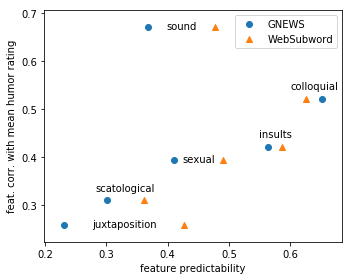

In [160]:
cat_display_names = {"sexc":"sexual", "scatc":"scatological", "inslt": "insults", "clq": "colloquial", "juxt": "juxtaposition", "snd": "sound"} 
rating_corrs = {cat: corr([labels[cat][w] for w in lab_words], [ultimate_scores[w] for w in lab_words]) for cat in cat_display_names}


figure(figsize=(5,4))  
scatter([correlations[cat] for cat in cat_display_names], [rating_corrs[cat] for cat in rating_corrs], label="GNEWS")
scatter([correlations_Efast[cat] for cat in cat_display_names], [rating_corrs[cat] for cat in rating_corrs], marker="^", label="WebSubword")

for cat, display in cat_display_names.items():
    y = rating_corrs[cat]
    x = (correlations[cat] + correlations_Efast[cat])/2
    if display in {"colloquial", "insults", "scatological"}:
        y+=0.02
    else:
        y-=0.005
    annotate(display, (x, y), horizontalalignment='center')

ylabel("feat. corr. with mean humor rating")
xlabel("feature predictability")
legend()
tight_layout()
savefig("figs/feature_correlations.jpg", dpi=300)

# word length analysis

In [149]:
median([len(w) for w in wordss[0] if "_" not in w]), median([len(w) for w in wordss[2] if "_" not in w])

(8.0, 7.0)

### Appendix: Generated E_fast for the 120k words+EH

In [ ]:


from gensim.models import FastText as fText
# FastText WITH SUBWORD, download from https://fasttext.cc/docs/en/english-vectors.html
E_fast_gensim = fText.load_fasttext_format("data/crawl-300d-2M-subword", encoding='iso-8859-1')
def get_fast_word(w):
    try:
        return normalize(E_fast_gensim[w.replace("_", " ")])
    except:
        return 0.0*E_fast_gensim["cat"]

E_fast_normalized_dict = {w: get_fast_word(w) for w in wordss[0]+list(EH)}
with open("data/crawl-300d-120k-subword_w_EH.pkl", "wb") as f:
    pkl.dump(E_fast_normalized_dict, f)
    
missing = []
for w in wordss[0]+list(EH_scores):
    try:
        E_fast_gensim[w.replace("_", " ")]
    except:
        missing.append(w)
print(len(missing), "missing words from FASTTEXT+EH:")
print(", ".join(missing))
# #12 missing words from FASTTEXT:
# #cu_ft, de_la, ejp, et_en, et_la, et_le, g_km, hjp, lb_ft, mm_x, ro_ro, yr_yr

In [116]:
def print_missing(E, words_of_interest = [("EH", list(EH_scores)), ("120k", wordss[0])]):
    for name, words in words_of_interest:
        missing = []
        for w in words:
            try:
                E[w.replace("_", " ")]
            except:
                missing.append(w)
        print(f"{len(missing):,} missing words ({len(missing)/len(words):.1%}).")
        if missing:
            print(", ".join(missing[:10]) + ("" if len(missing)<10 else ", ..."))

def vec_file2dict(vec_filename, pkl_filename):
    from gensim.models import KeyedVectors

    e = KeyedVectors.load_word2vec_format(vec_filename)
    def get_word(w):
        try:
            return normalize(e[w.replace("_", " ")])
        except:
            return 0.0*e["cat"]

    e_dict = {w: get_word(w) for name, words in words_of_interest for w in words}
    with open(pkl_filename, "wb") as f:
        pkl.dump(e_dict, f)

    print(f"Loaded '{vec_filename}' and wrote {len([v for v in e_dict.values() if not np.allclose(v, 0)]):,} nonzero vectors to '{pkl_filename}'")
        
    print_missing(e_dict)

In [ ]:
# FastText wiki news model, download from https://fasttext.cc/docs/en/english-vectors.html
vec_file2dict("data/wiki-news-300d-1M-subword.vec", "wiki-news-300d-120kEH-subword.pkl")

# Loaded 'data/wiki-news-300d-1M-subword.vec' and wrote 73,547 nonzero vectors to 'wiki-news-300d-120kEH-subword.pkl'
# 0 missing words (0.0%) from 'EH'.
# 46,712 missing words (38.9%) from '120k'.
# aaahs, aam_aadmi, aam_admi, ab_initio, abalone_diver, abated_somewhat, abbreviations_acronyms, abdominal_aneurysm, abdominal_aorta, abdominal_bloating, ...

In [303]:
# FastText (WITHOUT SUBWORD!), download from https://fasttext.cc/docs/en/english-vectors.html
vec_file2dict("data/crawl-300d-2M.vec", "data/crawl-300d-120k-w_EH.pkl")

Loaded 'data/crawl-300d-2M.vec' and wrote 74,448 nonzero vectors to 'data/crawl-300d-120k-w_EH.pkl'
0 missing words (0.0%) from 'EH'.
45,811 missing words (38.2%) from '120k'.
aam_aadmi, aam_admi, ab_initio, abalone_diver, abated_somewhat, abbreviations_acronyms, abdominal_aneurysm, abdominal_aorta, abdominal_bloating, abdominal_cavity, ...


In [114]:
def we_file2dict(we_filename, pkl_filename, words_of_interest = [("EH", list(EH_scores)), ("120k", wordss[0])]):
    E_original = we.WordEmbedding(we_filename)
    def get_word(w):
        try:
            return E_original[w]
        except:
            return 0.0*E_original["cat"]

    E_normalized_dict = {w: get_word(w) for w in wordss[0]+list(EH_scores)}
    with open(pkl_filename, "wb") as f:
        pkl.dump(E_normalized_dict, f)
    
    print_missing(E_normalized_dict)

In [311]:
# word2vec, trained on google news, 3 million tokens, download from https://code.google.com/archive/p/word2vec/ 
# (search for GoogleNews-vectors-negative300.bin.gz.)
we_file2dict("../../active_embedding/w2v_all.h5", "data/w2v_w_EH.pkl")

*** Reading data from ../../active_embedding/w2v_all.h5
3000000 words of dimension 300 : </s>, in, for, that, ..., Bim_Skala_Bim, Mezze_Cafe, pulverizes_boulders, snowcapped_Caucasus
0 missing words (0.0%).
45,353 missing words (37.8%).
aam_aadmi, aam_admi, ab_initio, abalone_diver, abated_somewhat, abbreviations_acronyms, abdominal_aneurysm, abdominal_aorta, abdominal_bloating, abdominal_cavity, ...


In [312]:
# Glove Wikipedia 2014 + Gigaword 5, 6B tokens, download from https://nlp.stanford.edu/projects/glove/
we_file2dict("../../active_embedding/glove.6B.300d.h5", "data/glove_w_EH.pkl")

*** Reading data from ../../active_embedding/glove.6B.300d.h5
400000 words of dimension 300 : the, ,, ., of, ..., kronik, rolonda, zsombor, sandberger
0 missing words (0.0%).
45,353 missing words (37.8%).
aam_aadmi, aam_admi, ab_initio, abalone_diver, abated_somewhat, abbreviations_acronyms, abdominal_aneurysm, abdominal_aorta, abdominal_bloating, abdominal_cavity, ...


In [117]:
# Glove common crawl, 840B tokens, download from https://nlp.stanford.edu/projects/glove/
we_file2dict("../../words/embeddings/glove.840B.300d.h5", "data/glove_840_w_EH.pkl")

*** Reading data from ../../words/embeddings/glove.840B.300d.h5
2196016 words of dimension 300 : ,, ., the, and, ..., yildirim, z/28, zipout, zulchzulu
0 missing words (0.0%).
45,353 missing words (37.8%).
aam_aadmi, aam_admi, ab_initio, abalone_diver, abated_somewhat, abbreviations_acronyms, abdominal_aneurysm, abdominal_aorta, abdominal_bloating, abdominal_cavity, ...


###  Addition to section feature predictability, checking predictability of whole words (no underscores) for comparison

In [321]:
print({cat: cross_val_corr(whole_words, labels[cat], n_reps=3, E=E_fast_whole) for cat in labels})
print({cat: cross_val_corr(whole_words, labels[cat], n_reps=3, E=E_fast) for cat in labels})
print({cat: cross_val_corr(whole_words, labels[cat], n_reps=3, E=E) for cat in labels})

{'snd': 0.468235278880151, 'scatc': 0.36508349788624556, 'clq': 0.6800853249251295, 'inslt': 0.6418714271504866, 'juxt': 0.32104158588568743, 'sexc': 0.4873402420133541}
{'snd': 0.49574126629361426, 'scatc': 0.36367857128885767, 'clq': 0.6661158922317334, 'inslt': 0.6166565097315345, 'juxt': 0.29614394047095777, 'sexc': 0.5368844730014255}
{'snd': 0.34131395617167654, 'scatc': 0.25900459922724695, 'clq': 0.6178840684335821, 'inslt': 0.5411348485843209, 'juxt': 0.14215428981882824, 'sexc': 0.3644700026481817}
